In [1]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2
from scipy.stats import ttest_ind
import seaborn

In [2]:
# !tar -xvzf inno_stats.tar.gz

In [3]:
bad_ids = pd.read_csv('bad_ids.csv')

In [4]:
bad_ids_set = set(bad_ids['id_card'])

In [5]:
bad_ids_set

{1310723,
 262151,
 1835015,
 1310735,
 1835024,
 19,
 393246,
 32,
 35,
 36,
 41,
 42,
 393259,
 49,
 50,
 51,
 131124,
 917557,
 524343,
 56,
 1441849,
 786492,
 1704005,
 71,
 1704008,
 524361,
 75,
 1179723,
 393292,
 79,
 1704015,
 81,
 80,
 1835091,
 1441876,
 1704018,
 393301,
 1179735,
 917593,
 92,
 96,
 98,
 99,
 1704037,
 104,
 105,
 393322,
 108,
 109,
 110,
 112,
 113,
 119,
 121,
 123,
 131198,
 130,
 131,
 524420,
 133,
 262275,
 134,
 131207,
 1310855,
 393357,
 151,
 1310872,
 917662,
 917665,
 162,
 524453,
 165,
 169,
 171,
 175,
 176,
 183,
 184,
 187,
 786622,
 191,
 1704130,
 195,
 197,
 199,
 200,
 1704139,
 203,
 208,
 211,
 212,
 213,
 393431,
 524504,
 218,
 220,
 226,
 227,
 232,
 1573096,
 235,
 236,
 1704173,
 246,
 251,
 252,
 253,
 131323,
 393471,
 258,
 131331,
 262,
 266,
 1835275,
 271,
 272,
 273,
 262417,
 131348,
 393496,
 281,
 655640,
 280,
 287,
 288,
 1048865,
 262433,
 786724,
 292,
 786726,
 295,
 300,
 393516,
 302,
 1442095,
 1048880,
 6556

In [6]:
df = pd.read_csv('09_groups.csv')

In [7]:
df

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.000,108.00,0.0,10004.0
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.000,108.00,0.0,10004.0
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.000,107.95,0.0,10004.0
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.000,108.00,0.0,10004.0
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.000,88.00,0.0,10091.0
...,...,...,...,...,...,...,...,...,...,...
36408012,2020-09-27 12:50:18,14154420,0.0,555931,19855,15829,0.428,40.51,0.0,-9999.0
36408013,2020-09-27 17:10:49,14509889,0.0,259194,19855,15829,0.654,62.10,0.0,-9999.0
36408014,2020-09-27 16:12:06,23132791,0.0,1627728,19855,15829,0.828,78.65,0.0,-9999.0
36408015,2020-09-27 14:30:32,744578,0.0,554803,19860,10834,1.000,117.00,0.0,10139.0


In [8]:
len(df)

36408017

In [9]:
df_clean = df[~df['id_card'].isin(bad_ids_set)]

In [10]:
len(df_clean)

33252223

In [11]:
prod_groups = pd.read_csv('./product_groups.csv', delimiter=';', encoding='windows-1251')
prod_groups.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


# Task 1. 
Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if a bunch of money is going to spend)

In [12]:
num_discounted_orders = len(df_clean[df_clean['is_green'] == 1])

In [13]:
num_discounted_orders

2231236

In [14]:
discounted_orders_set = set(df_clean[df_clean['is_green'] == 1]['id_doc'])

In [15]:
discounted_orders = df_clean[df_clean['id_doc'].isin(discounted_orders_set)].groupby(by=['id_doc'])['sum'].sum()

In [16]:
discounted_orders

id_doc
19          200.00
60           54.60
76          114.60
138          93.00
152         187.60
             ...  
23417713    325.80
23417738    985.33
23417762    920.40
23417845    216.00
23417862    144.00
Name: sum, Length: 914081, dtype: float64

In [17]:
non_discounted_sample = df_clean[~df_clean['id_doc'].isin(discounted_orders_set)].groupby(by=['id_doc'])['sum'].sum()

In [18]:
discounted_orders.mean()

604.0235402117958

In [19]:
len(discounted_orders)

914081

In [20]:
non_discounted_sample

id_doc
2            396.00
4           1597.00
5            254.00
16           709.06
18           707.00
             ...   
23417857      97.00
23417859     346.00
23417864     324.00
23417867     838.24
23417869      80.00
Name: sum, Length: 5076182, dtype: float64

In [21]:
discounted_orders.mean(), non_discounted_sample.sample(len(discounted_orders)).mean()

(604.0235402117958, 651.2867063312796)

In [22]:
# Perform T-test to compare means of our samples (discounted orders and non-discounted ones)
ttest_ind(discounted_orders, non_discounted_sample.sample(len(discounted_orders)))

Ttest_indResult(statistic=-51.12326064152354, pvalue=0.0)

If the statistical software renders a p value of 0.000 it means that the value is very low, with many "0" before any other digit. So the interpretation would be that the results are significant and we can reject the null hypothesis: meaning the means are ot equal. However, average sum of orders with discount is lower than sum of orders 

# Task 2.
Prove that the frequency of shopping grows around the wage taking days (1-6 days of each month, 20-26 days of each month)

In [23]:
df_clean.index = pd.to_datetime(df_clean['date'],format='%Y-%m-%d %H:%M:%S')
df_clean

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
date,,,,,,,,,,
2020-09-01 17:01:25,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.000,108.00,0.0,10004.0
2020-09-01 17:35:36,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.000,108.00,0.0,10004.0
2020-09-01 19:19:21,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.000,107.95,0.0,10004.0
2020-09-01 21:53:34,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.000,108.00,0.0,10004.0
2020-09-01 18:42:31,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.000,88.00,0.0,10091.0
...,...,...,...,...,...,...,...,...,...,...
2020-09-27 11:40:51,2020-09-27 11:40:51,15159442,6508558.0,86153,19844,0,1.000,45.00,0.0,10091.0
2020-09-27 12:50:18,2020-09-27 12:50:18,14154420,0.0,555931,19855,15829,0.428,40.51,0.0,-9999.0
2020-09-27 16:12:06,2020-09-27 16:12:06,23132791,0.0,1627728,19855,15829,0.828,78.65,0.0,-9999.0


In [24]:
number_of_checks_per_day = df_clean.groupby(by=[df_clean.index.day])['id_doc'].count()

In [25]:
number_of_checks_per_day = number_of_checks_per_day.to_frame().rename(columns={'id_doc': 'count'})

In [26]:
number_of_checks_per_day

,count
date,
1,1269893
2,1285415
3,1287425
4,1270192
5,1053459
6,1158077
7,1371646
8,1227093
9,1336351


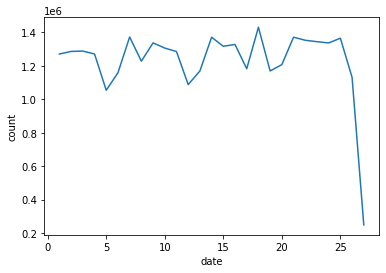

In [27]:
g = seaborn.lineplot(data=number_of_checks_per_day, x=number_of_checks_per_day.index, y="count")

After 5th day of month the number of checks increases and after 20th it increases sligtly and decreases after 25th. Probably, this means that people like to spend AVANS on some stuff and the rest of the salary to pay the bills.

# Task 3
Define such cohort existance:

1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly)
2. Average purchase sum - The customers that usually spend the same amount of money
3. Orders amount - The customers grouped by the total numer of orders
4. Usual cart - The customers grouped by the product groups

In [28]:
frequent_buyers = df_clean.groupby(by=['id_doc'])
frequent_buyers

In [30]:
# Orders amount
grouped_by_user = df_clean.groupby(by=['id_card'])
number_of_orders_per_user = grouped_by_user.agg({"id_doc": "nunique"})
number_of_orders_per_user.head()
grouped_by_number_of_orders = number_of_orders_per_user.groupby(by=['id_doc'])
grouped_by_number_of_orders.groups

{1: [1, 2, 7, 9, 13, 21, 29, 40, 44, 60, 62, 76, 85, 86, 87, 101, 114, 116, 124, 143, 153, 182, 186, 196, 205, 217, 223, 225, 229, 244, 254, 263, 274, 278, 279, 291, 308, 311, 313, 316, 323, 332, 337, 371, 372, 373, 380, 383, 385, 386, 387, 389, 397, 401, 402, 411, 416, 417, 418, 426, 427, 431, 433, 442, 443, 446, 448, 453, 454, 458, 460, 461, 470, 476, 478, 490, 493, 503, 504, 514, 523, 534, 543, 555, 557, 562, 579, 582, 595, 598, 607, 608, 609, 610, 613, 614, 621, 623, 625, 630, ...], 2: [8, 24, 33, 69, 70, 89, 111, 132, 147, 148, 164, 206, 250, 255, 260, 270, 289, 293, 348, 359, 425, 436, 440, 441, 450, 456, 466, 467, 477, 486, 513, 518, 532, 546, 559, 563, 568, 575, 577, 581, 584, 591, 592, 601, 616, 624, 638, 643, 647, 654, 695, 716, 737, 754, 764, 802, 809, 821, 822, 833, 851, 867, 885, 888, 889, 900, 901, 903, 908, 914, 938, 952, 963, 965, 970, 978, 995, 1003, 1028, 1045, 1047, 1048, 1052, 1065, 1066, 1075, 1087, 1107, 1115, 1127, 1154, 1156, 1157, 1182, 1207, 1212, 1220, 1223, 